<a href="https://colab.research.google.com/github/sashank1326/ML_Practice/blob/main/Titanic_Ml_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
df = pd.read_csv("/content/drive/MyDrive/ML_LAB/titanic_train.csv")

df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [4]:
df.dropna(axis = 1,thresh= 0.7*len(df),inplace = True)

# Filling the null values(numeric column) with median

numerical_cols = df.select_dtypes(include = ['int64','float64']).columns
categorical_cols = df.select_dtypes(include = ['int64','float64']).columns

df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [5]:
X = df.drop("Survived", axis=1)
y = df["Survived"]


# 2. Split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (712, 10)
Test shape: (179, 10)


In [6]:
constant_features = [col for col in X_train.columns if X_train[col].nunique() == 1]

print(constant_features)

[]


In [7]:
# 4. Quasi-constant features (based on threshold)
quasi_constant_features = []
threshold = 0.95

for col in X_train.columns:
    freq = X_train[col].value_counts(normalize=True).values[0]
    if freq >= threshold:
        quasi_constant_features.append(col)

print("Quasi-constant features:", quasi_constant_features)

X_train.drop(columns=quasi_constant_features, inplace=True)
X_test.drop(columns=quasi_constant_features, inplace=True)

Quasi-constant features: []


In [8]:
duplicated_features = []
cols = X_train.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if X_train[cols[i]].equals(X_train[cols[j]]):
            duplicated_features.append(cols[j])

print(duplicated_features)

[]


In [9]:
numeric_X_train = X_train.select_dtypes(include=['number'])

corr_matrix = numeric_X_train.corr()
corr_threshold = 0.98
corr_pairs = set()

# Find highly correlated features
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            corr_pairs.add(corr_matrix.columns[i])

print("Highly Correlated Features:", corr_pairs)

Highly Correlated Features: set()


[]

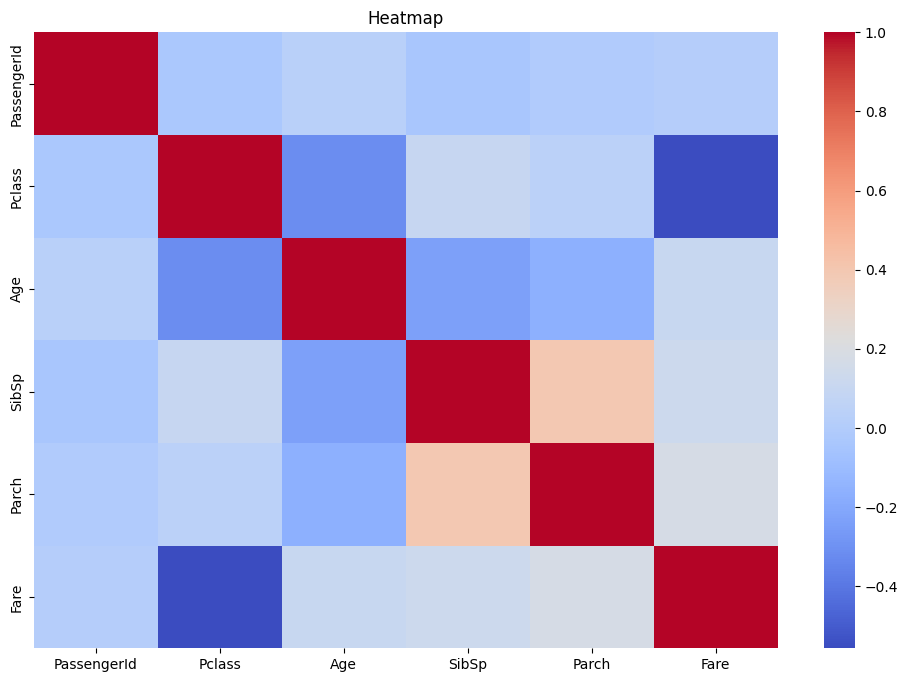

In [10]:
plt.figure(figsize = (12,8))
sns.heatmap(corr_matrix,annot=False,cmap = "coolwarm")
plt.title("Heatmap")
plt.plot()

In [11]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Select numeric features
numeric_X_train = X_train.select_dtypes(include=['number'])

# Compute MI scores
mi_scores = mutual_info_regression(numeric_X_train, y_train, discrete_features=False)

# Create DataFrame of results
mi_df = pd.DataFrame({
    "Features": numeric_X_train.columns,
    "MI Score": mi_scores
}).sort_values(by="MI Score", ascending=False)

# Select features with MI score < 0.01
# print(mi_df)
low_imp = mi_df[mi_df["MI Score"] < 0.01]["Features"].tolist()

print("Low Importance Features:", low_imp)

# Drop low importance features
X_train = X_train.drop(columns=low_imp)
X_test = X_test.drop(columns=low_imp)

Low Importance Features: ['PassengerId']


In [12]:
cat_features = X_train.select_dtypes(include=['object', 'category']).copy()

# Encode categorical features numerically
label_enc = LabelEncoder()
for col in cat_features.columns:
    cat_features[col] = cat_features[col].astype(str)  # Handle NaN as string
    cat_features[col] = label_enc.fit_transform(cat_features[col])

# Apply Chi-square test
chi_scores, p_values_chi = chi2(cat_features, y_train)

chi_df = pd.DataFrame({
    'Feature': cat_features.columns,
    'Chi2_Score': chi_scores,
    'P_Value': p_values_chi
}).sort_values(by='Chi2_Score', ascending=False)

print("Chi-Square Test Results (Categorical Features):")
print(chi_df)

Chi-Square Test Results (Categorical Features):
    Feature   Chi2_Score       P_Value
2    Ticket  2058.884368  0.000000e+00
0      Name   360.798816  1.886447e-80
1       Sex    76.301994  2.434380e-18
3  Embarked    10.099757  1.482889e-03


In [13]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).copy()

# Scale features (optional for ANOVA stability)
scaler = MinMaxScaler()
num_scaled = scaler.fit_transform(num_features)

# Apply ANOVA F-test for classification
f_scores, p_values_anova = f_classif(num_scaled, y_train)

anova_df = pd.DataFrame({
    'Feature': num_features.columns,
    'F_Score': f_scores,
    'P_Value': p_values_anova
}).sort_values(by='F_Score', ascending=False)

print("\nANOVA Test Results (Numeric Features):")
print(anova_df)


ANOVA Test Results (Numeric Features):
  Feature    F_Score       P_Value
0  Pclass  97.835853  1.064770e-21
4    Fare  58.314907  7.230704e-14
3   Parch   5.066904  2.469201e-02
1     Age   4.142223  4.219711e-02
2   SibSp   0.484537  4.866020e-01


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
import numpy as np

# **Wrraper**

In [15]:
df = df.drop(["PassengerId", "Name", "Ticket"], axis=1)
df = pd.get_dummies(df, drop_first=True)

In [16]:
df.head()
X = df.drop("Survived", axis=1)
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
sfs_forward = SFS(RandomForestClassifier(),
                  k_features=5,
                  forward=True,
                  floating=False,
                  verbose=2,
                  scoring='accuracy',
                  cv=3)

sfs_forward = sfs_forward.fit(X_train, y_train)

print("Forward Selection Features:", X_train.columns[list(sfs_forward.k_feature_idx_)])

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.1s finished

[2025-08-23 08:13:12] Features: 1/5 -- score: 0.7893368317791252[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.0s finished

[2025-08-23 08:13:16] Features: 2/5 -- score: 0.7963514519731945[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.4s finished

[2025-08-23 08:13:20] Features: 3/5 -- score: 0.8005885898663263[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished

[2025-08-23 08:13:23] Features: 4/5 -- score: 0.8033897103145056

Forward Selection Features: Index(['Pclass', 'Age', 'SibSp', 'Sex_male', 'Embarked_S'], dtype='object')


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.5s finished

[2025-08-23 08:13:28] Features: 5/5 -- score: 0.8216383599853444

In [ ]:
sfs_backward = SFS(RandomForestClassifier(),
                   k_features=5,
                   forward=False,
                   floating=False,
                   verbose=2,
                   scoring='accuracy',
                   cv=3)

sfs_backward = sfs_backward.fit(np.array(X_train), y_train)
print("Backward Selection Features:", X_train.columns[list(sfs_backward.k_feature_idx_)])

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.4s finished

[2025-08-21 14:46:36] Features: 7/5 -- score: 0.8104043305085747[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    9.8s finished

[2025-08-21 14:46:45] Features: 6/5 -- score: 0.8118048907326644

Backward Selection Features: Index(['Pclass', 'Age', 'Parch', 'Fare', 'Sex_male'], dtype='object')


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.7s finished

[2025-08-21 14:46:55] Features: 5/5 -- score: 0.8103925114349537

In [ ]:
lr = LogisticRegression(max_iter=500)

efs = EFS(estimator=lr,
          min_features=1,
          max_features=4,
          scoring='accuracy',
          cv=5)

efs = efs.fit(X_train, y_train)
print("Best Accuracy Score (EFS):", efs.best_score_)
print("Best subset indices (EFS):", efs.best_idx_)
print("Best subset names (EFS):", efs.best_feature_names_)

Features: 162/162

Best Accuracy Score (EFS): 0.7991923569388358
Best subset indices (EFS): (0, 1, 5, 7)
Best subset names (EFS): ('Pclass', 'Age', 'Sex_male', 'Embarked_S')


In [ ]:
model = LogisticRegression(max_iter=500)
rfe = RFE(model, n_features_to_select=5)
rfe = rfe.fit(X_train, y_train)

print("RFE Selected Features:", X_train.columns[rfe.support_].tolist())
print("RFE Feature Ranking:", rfe.ranking_)

RFE Selected Features: ['Pclass', 'SibSp', 'Sex_male', 'Embarked_Q', 'Embarked_S']
RFE Feature Ranking: [1 3 1 2 4 1 1 1]


# Logistic **Regression**

In [18]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [22]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/ML_LAB/titanic_train.csv")
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [46]:
from sklearn.linear_model import LogisticRegression

le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])

X = df[['Sex']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = LogisticRegression()
model.fit(X_train, y_train)

 # Predicting on the test set
y_pred = model.predict(X_test)

# Create a DataFrame with YrSold, actual, and predicted prices
results_df = X_test.copy()
results_df['Actual_survival'] = y_test.values
results_df['Predicted_Survival'] = y_pred

# Print the resulting DataFrame
print(results_df.head(20))  # print first 10 rows

     Sex  Actual_survival  Predicted_Survival
521    1                0                   0
618    0                1                   1
260    1                0                   0
777    0                1                   1
766    1                0                   0
720    0                1                   1
481    1                0                   0
411    1                0                   0
430    1                1                   0
63     1                0                   0
522    1                0                   0
504    0                1                   1
355    1                0                   0
664    1                1                   0
335    1                0                   0
457    0                1                   1
70     1                0                   0
875    0                1                   1
241    0                1                   1
719    1                0                   0


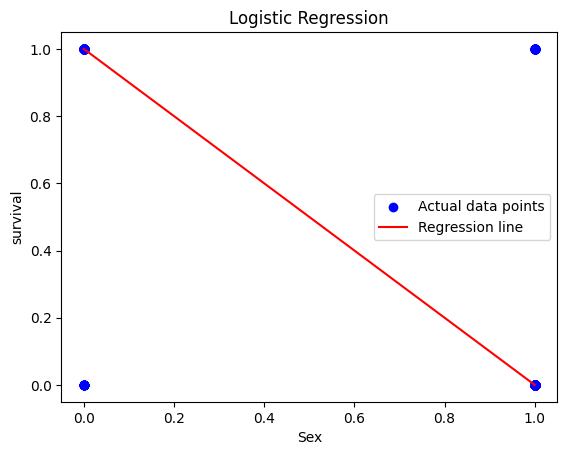

In [47]:
# Plotting
plt.scatter(X_test, y_test, color='blue', label='Actual data points')
plt.plot(X_test, y_pred, color='red', label='Regression line')
plt.xlabel('Sex')
plt.ylabel('survival')
plt.title('Logistic Regression')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


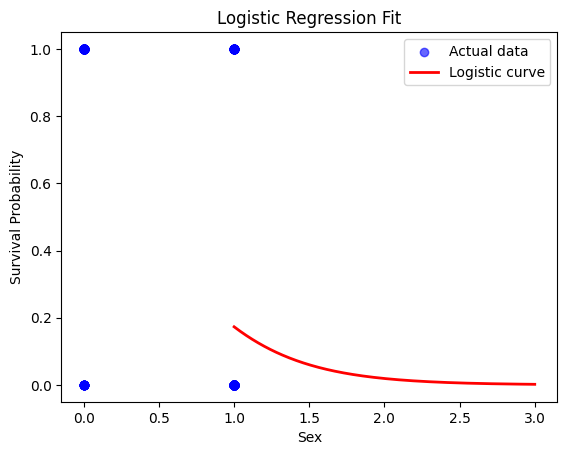

In [48]:
import numpy as np

# Generate smooth values of Pclass (1 to 3)
X_vals = np.linspace(1, 3, 300).reshape(-1,1)
y_probs = model.predict_proba(X_vals)[:,1]  # probability of survival = 1

# Plot actual data
plt.scatter(X_test, y_test, color='blue', alpha=0.6, label='Actual data')

# Plot logistic regression curve
plt.plot(X_vals, y_probs, color='red', linewidth=2, label='Logistic curve')

plt.xlabel('Sex')
plt.ylabel('Survival Probability')
plt.title('Logistic Regression Fit')
plt.legend()
plt.show()